In [7]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import numpy as np
import random

def fix_seed():
    np.random.seed(42)
    torch.manual_seed(42)
    random.seed(42)
    torch.cuda.manual_seed(42)

In [3]:
from samplers import get_data_sampler
from tasks import get_task_sampler



In [22]:
from tqdm.notebook import tqdm

def compute_decision_boundary(task_name, run_id, noise_prob=None):
    model, conf = get_model_from_run(f"../models/{task_name}/{run_id}")

    n_dims = conf.model.n_dims
    batch_size = conf.training.batch_size

    data_sampler = get_data_sampler(conf.training.data, n_dims)
    task_sampler = get_task_sampler(
        conf.training.task,
        n_dims,
        batch_size,
        **conf.training.task_kwargs
    )
    task = task_sampler()
    if noise_prob:
        task.train_noise_prob = noise_prob
    xs = data_sampler.sample_xs(b_size=1, n_points=conf.training.curriculum.points.end, seeds=[2])
    ys = task.evaluate(xs)
    xs_flat, ys_flat = xs[0], ys[0]
    xs_flat_ones = xs_flat[ys_flat == 1]
    xs_flat_zeros = xs_flat[ys_flat == -1]

    ones = torch.zeros((0, 2))
    zeros = torch.zeros((0, 2))
    x_ticks, y_ticks = 70, 70
    with torch.no_grad():
        for x in tqdm(torch.linspace(-3, 3, x_ticks)):
            y_coords = torch.linspace(-3, 3, y_ticks)
            test_xs = torch.tile(xs, (y_ticks, 1, 1))
            test_xs[:, -1, 0] = x
            test_xs[:, -1, 1] = y_coords
            test_ys = task.evaluate(test_xs)
            pred = model(test_xs, test_ys)[:, -1].flatten()
            ones_mask = pred > 0
            # deal with ones
            y_coords_ones = y_coords[ones_mask]
            x_coords_ones = torch.ones_like(y_coords_ones) * x
            ones = torch.cat((ones, torch.stack((x_coords_ones, y_coords_ones), dim=1)))

            # deal with zeros
            y_coords_zeros = y_coords[~ones_mask]
            x_coords_zeros = torch.ones_like(y_coords_zeros) * x
            zeros = torch.cat((zeros, torch.stack((x_coords_zeros, y_coords_zeros), dim=1)))

    db_radius = get_rbf_db(task.center, xs_flat).item()

    return task, ones, zeros, xs_flat_ones, xs_flat_zeros, db_radius

def plot_decision_boundary(task, ones, zeros, xs_flat_ones, xs_flat_zeros, db_radius):
    fig, ax = plt.subplots()
    ax.set_title("Decision Boundary Visualization")
    ax.set_aspect(1)
    ax.scatter(ones[:, 0], ones[:, 1])
    ax.scatter(zeros[:, 0], zeros[:, 1])
    ax.scatter(xs_flat_ones[:, 0], xs_flat_ones[:, 1])
    ax.scatter(xs_flat_zeros[:, 0], xs_flat_zeros[:, 1])
    ax.scatter(task.center[0], task.center[1], marker='x')
    db = plt.Circle((task.center[0], task.center[1]), db_radius, fill=False, color='red')
    ax.add_patch(db)
    plt.show()

    
def get_rbf_db(center, xs_b):
    broadcast_center = center.reshape(1, 1, center.shape[0])
    dist = (torch.cdist(xs_b, broadcast_center).squeeze(-1))
    medians, _ = torch.median(dist, dim=1, keepdim=True)
    medians += 1e-6
    return medians

In [5]:
fix_seed()
task, ones, zeros, xs_flat_ones, xs_flat_zeros, db_radius = compute_decision_boundary("rbf_lr_dim2", "trained")

  0%|          | 0/70 [00:00<?, ?it/s]

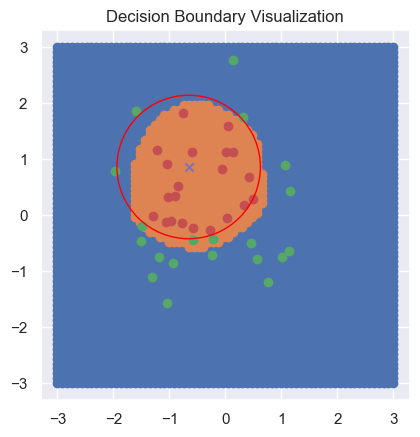

In [6]:
plot_decision_boundary(task, ones, zeros, xs_flat_ones, xs_flat_zeros, db_radius)

In [25]:
fix_seed()
task, ones, zeros, xs_flat_ones, xs_flat_zeros, db_radius = compute_decision_boundary("rbf_lr_dim2_noise0.1", "trained", 0.05)

  0%|          | 0/70 [00:00<?, ?it/s]

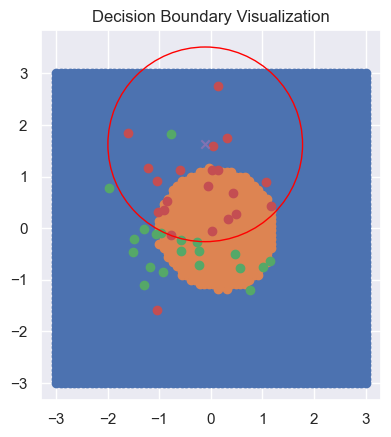

In [27]:
plot_decision_boundary(task, ones, zeros, xs_flat_ones, xs_flat_zeros, db_radius)

d:\UserFiles\Programming\Anaconda\envs\icl\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\UserFiles\Programming\Anaconda\envs\icl\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


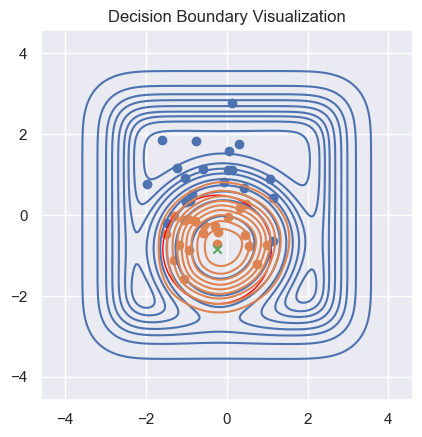

In [7]:
fig, ax = plt.subplots()
ax.set_title("Decision Boundary Visualization")
ax.set_aspect(1)
sns.kdeplot(ones[:, 0], ones[:, 1])
sns.kdeplot(zeros[:, 0], zeros[:, 1])
ax.scatter(xs_flat_ones[:, 0], xs_flat_ones[:, 1])
ax.scatter(xs_flat_zeros[:, 0], xs_flat_zeros[:, 1])
ax.scatter(task.center[0], task.center[1], marker='x')
db = plt.Circle((task.center[0], task.center[1]), db_radius, fill=False, color='red')
ax.add_patch(db)
plt.show()